# Introduction

In this notebook, basic error correction is explored for dealing with bit flip and phase flip errors in a circuit that prepares a bell state. After the 9 qubit Shor code is implemented to correct phase and bit flip errors, a noise mitigation technique is explored using a simulated depolarizing noise model and real hardware.

First, I import relevant libraries and connect accounts to quantum infrastructure providers such as IBM. 

In [1]:
from qiskit import IBMQ, execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Operator
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error
from qiskit.ignis.mitigation import complete_meas_cal, CompleteMeasFitter
from qiskit.tools.visualization import plot_histogram

from collections import Counter
import random

In [2]:
IBMQ.save_account('<input_your_personal_token_here>', overwrite=True)
provider = IBMQ.load_account()

C:\ProgramData\Miniconda3\envs\pyQ\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


# Step 1

Now I create a simple circuit to prepare the bell state. This puts the first qubit in superposition with an equal chance of measuring 0 or 1, then followed by a CNOT gate which entangles the first qubit with the second. The expected output results in a 50% chance of being either the 00 states or the 11 states.
$$\newcommand\bra[2][]{#1\langle {#2} #1\rvert}$$
$$\newcommand\ket[2][]{#1\lvert {#2} #1\rangle}$$
$$\ket{\Psi}=\frac{\ket{00} + \ket{11}}{\sqrt{2}}$$

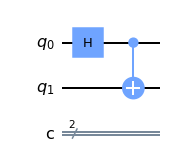

In [3]:
q = QuantumRegister(2, 'q')
c = ClassicalRegister(2, 'c')
bell_circuit = QuantumCircuit(q, c)

bell_circuit.h(0)
bell_circuit.cx(0, 1)

bell_circuit.draw(output='mpl')

# Step 2

Next, run the cell below which takes input from the user for both the probability of a bit flip error and phase flip error. If you do not enter valid probability values that sum to 1.00 or you press the **Enter** key, the default values of 40% will be used.

In [4]:
try: 
    print('Choose a bit flip probability between 0.00 - 1.00')
    bit_flip_prob = float(input())
    print(f'\nChoose a phase flip probability between 0.00 - {1.0-bit_flip_prob:.2f}')
    phase_flip_prob = float(input())

    if (float(bit_flip_prob) + float(phase_flip_prob) > 1.0):
        bit_flip_prob = 0.40
        phase_flip_prob = 0.40
        print('\nPlease choose probabilities that add to be less than or equal to 1.')
        print('Default values will be used.')

except ValueError:
    bit_flip_prob = 0.40
    phase_flip_prob = 0.40
    print('Default values will be used.')
    
print(f'\nThe probability to for a bit flip is {bit_flip_prob:.2f}')
print(f'The probability to for a phase flip is {phase_flip_prob:.2f}')
print(f'The probability to for a no error is {1.0-phase_flip_prob-bit_flip_prob:.2f}')

Choose a bit flip probability between 0.00 - 1.00

Default values will be used.

The probability to for a bit flip is 0.40
The probability to for a phase flip is 0.40
The probability to for a no error is 0.20


Now, to show the error type is being selected with the inputted probabilities we check statistically over 1000 iterations to see how the simulated outcomes compare to the expected results.

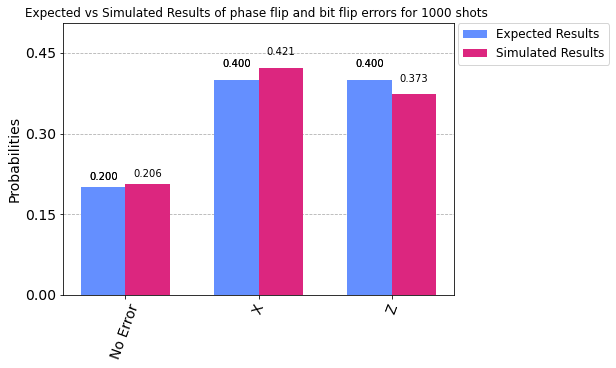

In [5]:
error_gate = ['No Error', 'X', 'Z']

outcomes = random.choices(error_gate, 
                          weights=((1-bit_flip_prob-phase_flip_prob)*100, bit_flip_prob*100, phase_flip_prob*100), 
                          k=1000)

expected_results = {'No Error': 1.0-phase_flip_prob-bit_flip_prob, 'X': bit_flip_prob, 'Z': phase_flip_prob}
simulated_counts = dict(Counter(outcomes))
plot_histogram([expected_results, simulated_counts], legend=['Expected Results', 'Simulated Results'],
              title='Expected vs Simulated Results of phase flip and bit flip errors for 1000 shots ')

You can run the cell below to generate a new combination of single-qubit errors based on the weighted probability of each error occurring, selected at the start of Step 2. 

qubit 0 error: ['Z']
qubit 1 error: ['Z']


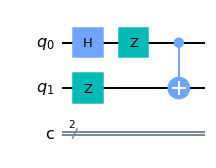

In [6]:
q0_err = random.choices(error_gate, weights=((1-bit_flip_prob-phase_flip_prob)*100, bit_flip_prob*100, phase_flip_prob*100), k=1)
q1_err = random.choices(error_gate, weights=((1-bit_flip_prob-phase_flip_prob)*100, bit_flip_prob*100, phase_flip_prob*100), k=1)
print('qubit 0 error:', q0_err)
print('qubit 1 error:', q1_err)

circuit = QuantumCircuit(q, c)

circuit.h(q[0])
    
if (q0_err[0] == 'X'):
    circuit.x(0)
elif (q0_err[0] == 'Z'):
    circuit.z(0)

if (q1_err[0] == 'X'):
    circuit.x(1)
elif (q1_err[0] == 'Z'):
    circuit.z(1)

circuit.cx(q[0], q[1])

circuit.draw(output='mpl')

Lets now generalize the single qubit error into a function so it can be applied to the circuit given the outcome of error type.

In [7]:
def error_op(error_type):
    if (error_type[0] == 'X'):
        return Operator([[0,  1],
                         [1,  0]])
    elif (error_type[0] == 'Z'):
        return Operator([[1,  0],
                         [0, -1]])
    else:
        return Operator([[1,  0],
                         [0,  1]])

# Step 3

Now I implement a 9-qubit Shor [9,1,3] error-correcting code on both qubits to correct for both bit flip and phase flip errors. To show that the second logical qubit has the identical code to the first logical qubit, the values are displaced by 8.

A survey paper that goes through many error-correcting codes and methodologies, **Quantum Error Correction for Beginners** was a helpful guide in this implementation. The original paper from Peter Shor is shown below as well. 

[S. Devitt; W. Munro; K. Nemoto. Quantum Error Correction for Beginners. 2013, arXiv:0905.2794](https://arxiv.org/pdf/0905.2794.pdf)

[P.W. Shor. Scheme for reducing decoherence in quantum computer memory. Phys. Rev. A., 52:R2493, 1995](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.52.R2493)

qubit 0 error: Z
qubit 1 error: Z

Results: {'00': 502, '11': 498}


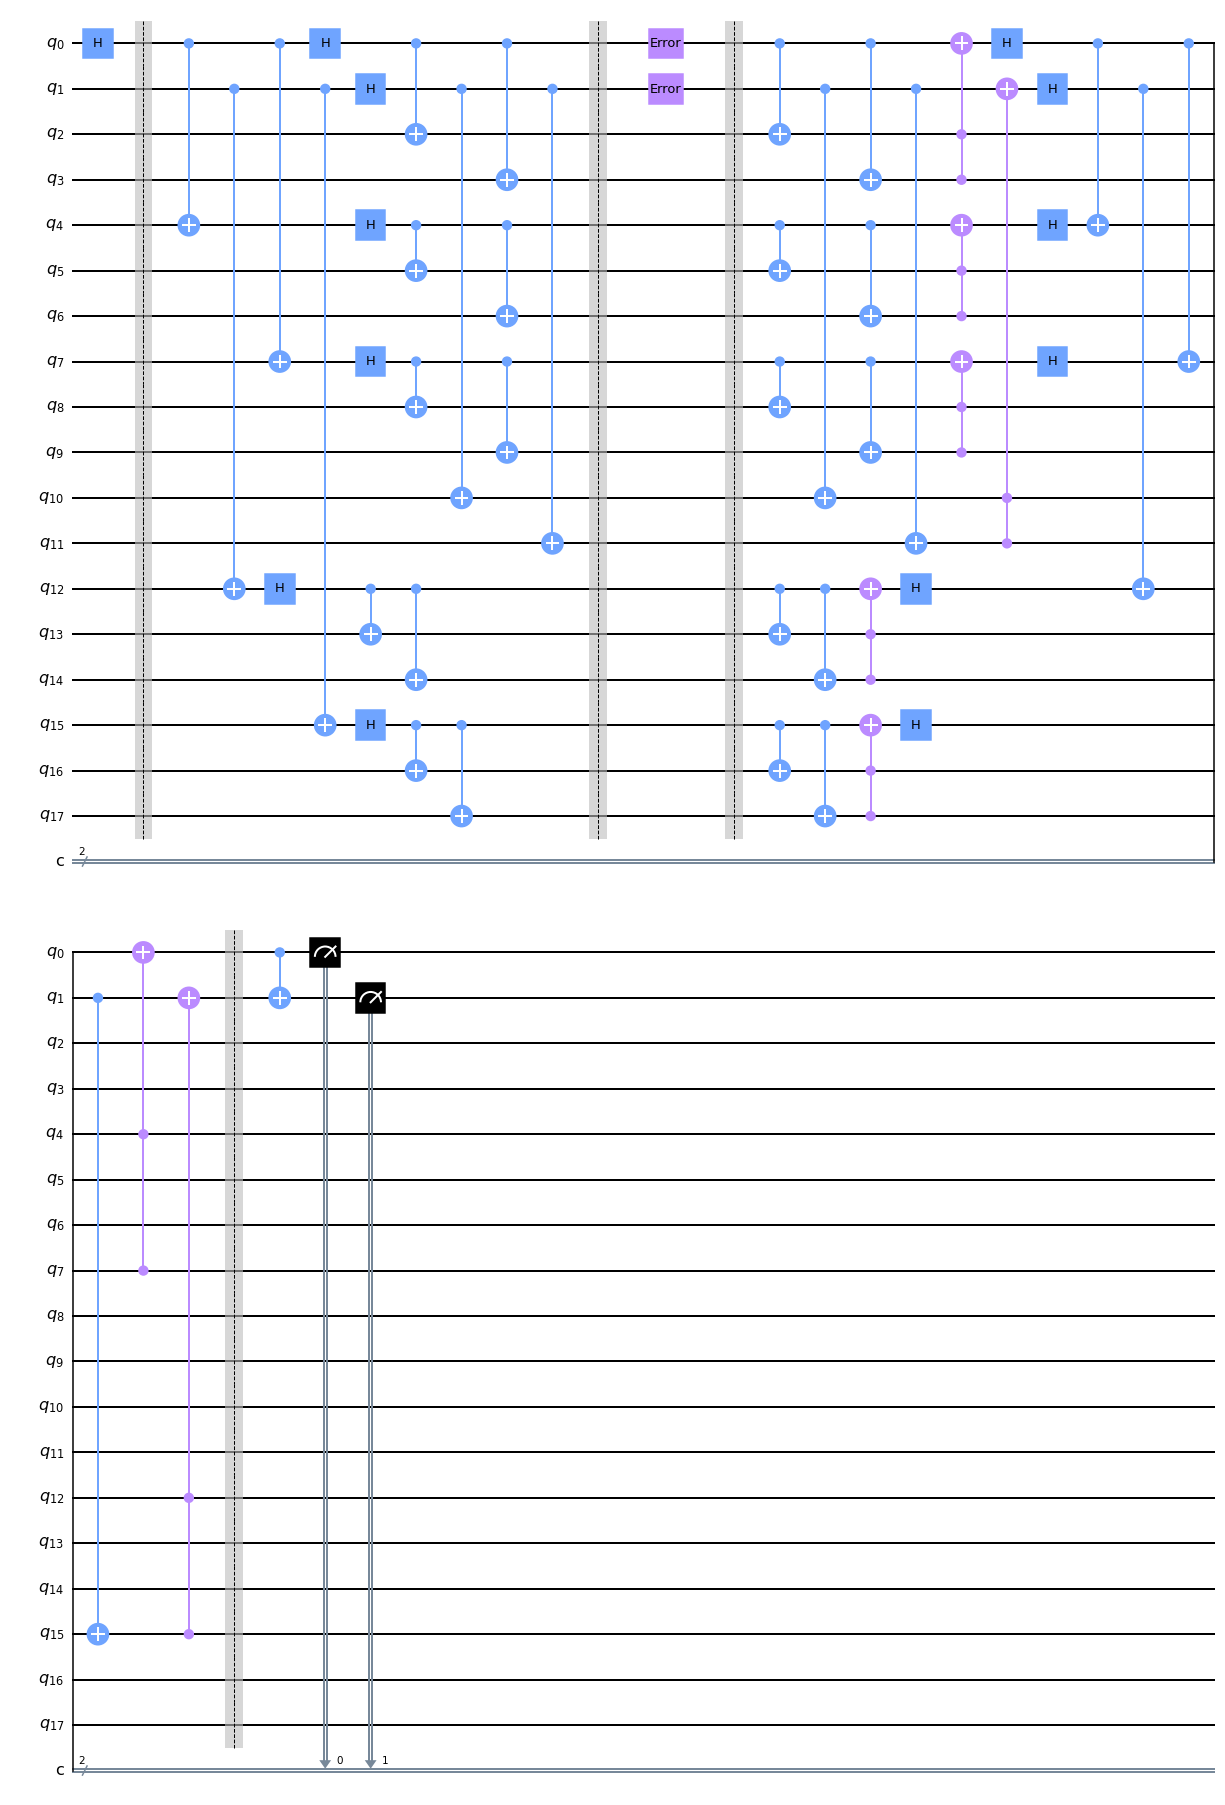

In [8]:
def run_circuit(q0_err='No Error', q1_err='No Error', backend=provider.get_backend('ibmq_qasm_simulator'), execute_job=True):

    #Create an 18 qubit register to represent 2 logical qubits
    q = QuantumRegister(18,'q')
    c = ClassicalRegister(2,'c')

    circuit = QuantumCircuit(q,c)

    #Hadamard gate for the bell state
    circuit.h(q[0]) 

    circuit.barrier(q)

    #First we implement a circuit for encoding a qubit to correct for phase flip errors
    circuit.cx(q[0],q[4])
    circuit.cx(q[1],q[4+8])
    circuit.cx(q[0],q[7])
    circuit.cx(q[1],q[7+8])

    circuit.h(q[0])
    circuit.h(q[1])
    circuit.h(q[4])
    circuit.h(q[4+8])
    circuit.h(q[7])
    circuit.h(q[7+8])

    #Next we implement a circuit for encoding a qubit to correct for bit flip errors
    circuit.cx(q[0],q[2])
    circuit.cx(q[1],q[2+8])
    circuit.cx(q[4],q[5])
    circuit.cx(q[4+8],q[5+8])
    circuit.cx(q[7],q[8])
    circuit.cx(q[7+8],q[8+8])

    circuit.cx(q[0],q[3])
    circuit.cx(q[1],q[3+8])
    circuit.cx(q[4],q[6])
    circuit.cx(q[4+8],q[6+8])
    circuit.cx(q[7],q[9])
    circuit.cx(q[7+8],q[9+8])

    circuit.barrier(q)
    
    #Here is where the error can occur
    circuit.unitary(error_op(q0_err),[0],label='error')
    circuit.unitary(error_op(q1_err),[1],label='error')

    circuit.barrier(q)
    
    #Now we implement a circuit for decoding a qubit to correct for bit flip errors
    circuit.cx(q[0],q[2])
    circuit.cx(q[1],q[2+8])
    circuit.cx(q[4],q[5])
    circuit.cx(q[4+8],q[5+8])
    circuit.cx(q[7],q[8])
    circuit.cx(q[7+8],q[8+8])

    circuit.cx(q[0],q[3])
    circuit.cx(q[1],q[3+8])
    circuit.cx(q[4],q[6])
    circuit.cx(q[4+8],q[6+8])
    circuit.cx(q[7],q[9])
    circuit.cx(q[7+8],q[9+8])

    circuit.ccx(q[2],q[3],q[0])
    circuit.ccx(q[2+8],q[3+8],q[1])
    circuit.ccx(q[5],q[6],q[4])
    circuit.ccx(q[5+8],q[6+8],q[4+8])
    circuit.ccx(q[9],q[8],q[7])
    circuit.ccx(q[9+8],q[8+8],q[7+8])

    #Now we implement a circuit for decoding a qubit to correct for phase flip errors
    circuit.h(q[0])
    circuit.h(q[1])
    circuit.h(q[4])
    circuit.h(q[4+8])
    circuit.h(q[7])
    circuit.h(q[7+8])

    circuit.cx(q[0],q[4])
    circuit.cx(q[1],q[4+8])
    circuit.cx(q[0],q[7])
    circuit.cx(q[1],q[7+8])
    circuit.ccx(q[7],q[4],q[0])
    circuit.ccx(q[7+8],q[4+8],q[1])

    circuit.barrier(q)
    
    #CNOT gate for the bell state
    circuit.cx(q[0],q[1])

    circuit.measure([q[0],q[1]],[c[0],c[1]])

    #A condition that allows the user to get the circuit without executing if needed
    if execute_job == True:
        job = execute(circuit, backend, shots=1000)

        counts = job.result().get_counts()

        print('qubit 0 error:', q0_err)
        print('qubit 1 error:', q1_err)
        print('\nResults:', counts)

        return circuit, counts
    else:
        return circuit
    
shor_circuit, shor_counts = run_circuit(q0_err[0], q1_err[0])
shor_circuit.draw(output='mpl')

A visualization of the circuit is shown above. Note that the barrier is only shown as a visual cue to separate the error-correcting elements from the original circuit. Barriers only come into play during the transpile or execute functions in Qiskit.

# Step 4

Let's show the measurement results and compare them to the expected outcome of the bell state circuit which has a 50% chance of being 00 and a 50% chance of being 11.

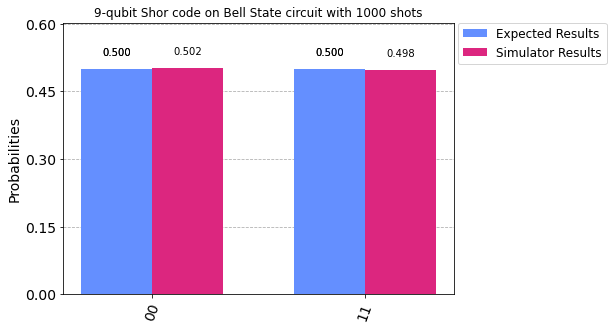

In [9]:
expected_results ={'00': 50, '11': 50}
plot_histogram([expected_results, shor_counts], 
               legend=['Expected Results', 'Simulator Results'],
               title='9-qubit Shor code on Bell State circuit with 1000 shots')

Looks like it is working, however, this does not give us visibility for the error-correcting code working across all possible combinations for the first two qubits. Let’s run the circuit for each combination and compare it to the expected results. 

In [10]:
import itertools
possible_errors = [p for p in itertools.product(['X','Z','I'], repeat=2)]

counts_total = []

for error in possible_errors:
    print('\n--------------------------------')
    print('\nError: ',error)
    circuit, counts = run_circuit(error[0],error[1])
    counts_total.append(counts)

#Add expected results to the front of the list
counts_total.insert(0, expected_results)


--------------------------------

Error:  ('X', 'X')
qubit 0 error: X
qubit 1 error: X

Results: {'00': 531, '11': 469}

--------------------------------

Error:  ('X', 'Z')
qubit 0 error: X
qubit 1 error: Z

Results: {'00': 517, '11': 483}

--------------------------------

Error:  ('X', 'I')
qubit 0 error: X
qubit 1 error: I

Results: {'00': 479, '11': 521}

--------------------------------

Error:  ('Z', 'X')
qubit 0 error: Z
qubit 1 error: X

Results: {'00': 508, '11': 492}

--------------------------------

Error:  ('Z', 'Z')
qubit 0 error: Z
qubit 1 error: Z

Results: {'00': 497, '11': 503}

--------------------------------

Error:  ('Z', 'I')
qubit 0 error: Z
qubit 1 error: I

Results: {'00': 525, '11': 475}

--------------------------------

Error:  ('I', 'X')
qubit 0 error: I
qubit 1 error: X

Results: {'00': 502, '11': 498}

--------------------------------

Error:  ('I', 'Z')
qubit 0 error: I
qubit 1 error: Z

Results: {'00': 504, '11': 496}

-------------------------------

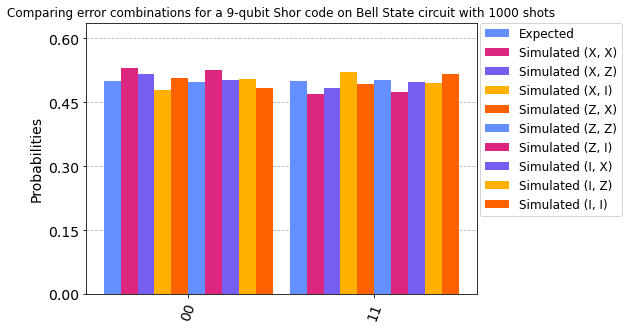

In [11]:
plot_histogram(counts_total,legend=['Expected',
                                    'Simulated (X, X)', 'Simulated (X, Z)',
                                    'Simulated (X, I)', 'Simulated (Z, X)', 
                                    'Simulated (Z, Z)', 'Simulated (Z, I)',
                                    'Simulated (I, X)', 'Simulated (I, Z)',
                                    'Simulated (I, I)'], title='Comparing error combinations for a 9-qubit Shor code on Bell State circuit with 1000 shots',
                                    bar_labels=False)

As shown above, not a single 01 or 10 output was found in all combinations which shows that this works for bit flip and phase flip errors in the first two qubits between the bell state preparation circuit. 

# Step 5

In the Noisy intermediate-scale quantum (NISQ) era, running conventional quantum error-correcting codes, even in the stabilizer formalism will require many redundancy layers for stable qubit operation due to various types of noise. 

Let’s see what happens when simulating a simple depolarizing noise model with 10% chance of single gate and CNOT gate errors while executing the 9-qubit Shor [9,1,3] error-correcting circuit we compiled above. 

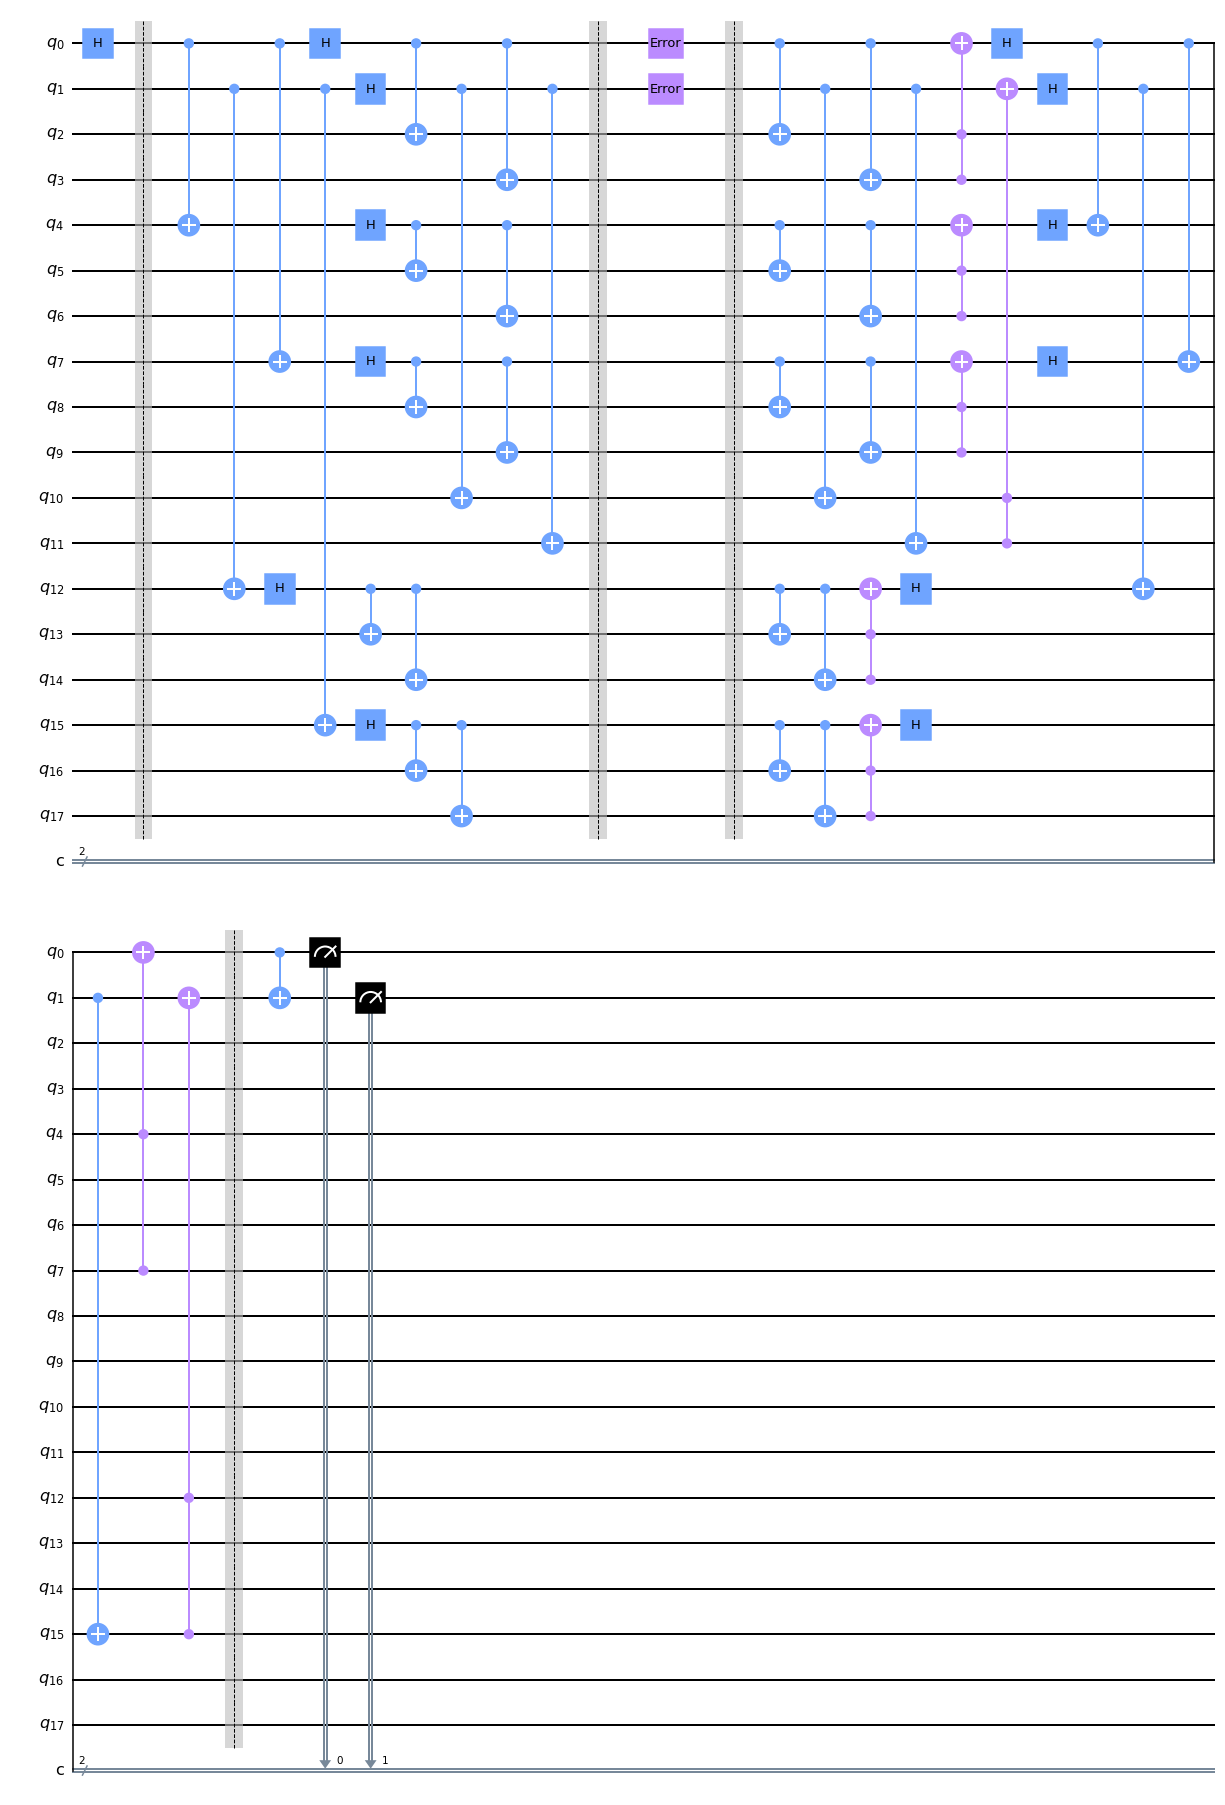

In [12]:
#Given the probabilities of single gate and CNOT gate errors, output a simple depolarizing noise model
def depolarizing_noise_model(prob_1 = 0.1, prob_2 = 0.1):
    
    #Introduce errors caused by simulated depolarizing noise
    error_1 = depolarizing_error(prob_1, 1)
    error_2 = depolarizing_error(prob_2, 2)

    #Include single gate and CNOT gate errors to noise model
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    
    return noise_model

noise_model = depolarizing_noise_model()

#get basis gates from noise model
basis_gates = noise_model.basis_gates

shor_circuit = run_circuit(execute_job=False)
shor_circuit.draw(output='mpl')

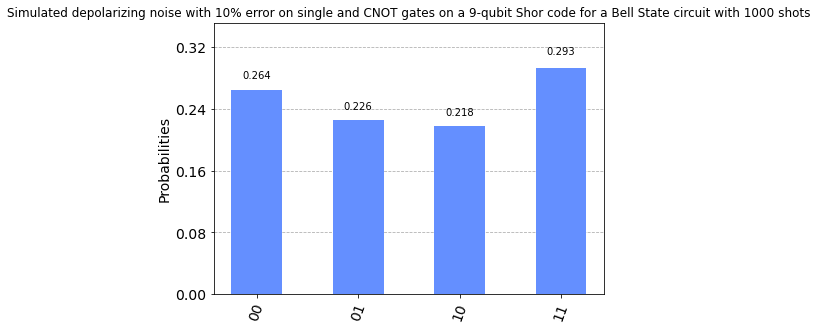

In [13]:
#perform a noise simulation
result = execute(shor_circuit, backend=provider.get_backend("ibmq_qasm_simulator"),
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
shor_circuit_noise_counts = result.get_counts()
plot_histogram(shor_circuit_noise_counts,
               title='Simulated depolarizing noise with 10% error on single and CNOT gates on a 9-qubit Shor code for a Bell State circuit with 1000 shots')

As you can see, due to the larger circuit depth there is too much noise and the 01 and 10 states are difficult to distinguish from the expected 00 and 11 states. 

A technique we can use is noise mitigation from the qiskit ignis library, where we can first build a set of calibration circuits based on the original circuit and then apply a filter to the output to mitigate the errors.

**NOTE:** The reason we **do not** want to do this particular method on the 18 qubit circuit, is the complete_meas_cal function in qiskit ignis will take a circuit of $n$ qubits and output $2^{n}$ circuits. Since $2^{18} = 262144$ circuits, this is is not a practical compuation for demonstration purposes. 

Measuring the original bell state with high depolarizing noise will allow us to see the effect of filtering the results based the calibration circuits.

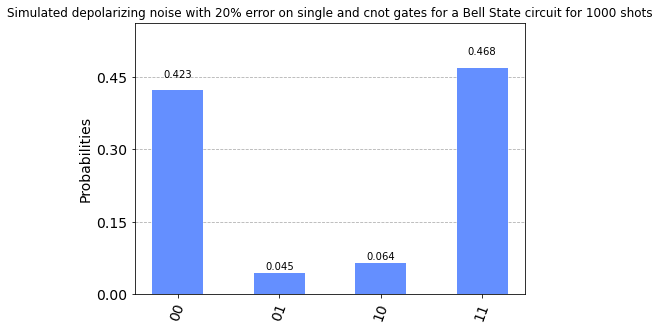

In [14]:
#measure our bell state circuit from step 1
bell_circuit.measure([q[0],q[1]],[c[0],c[1]])

#This time lets increase the single gate and CNOT gate errors to 20%
noise_model = depolarizing_noise_model(0.20, 0.20)

noise_simulated_result = execute(bell_circuit, backend=provider.get_backend("ibmq_qasm_simulator"),
                                 basis_gates=basis_gates, noise_model=noise_model, shots=1000).result()

noise_simulated_counts = noise_simulated_result.get_counts()
plot_histogram(noise_simulated_counts, title='Simulated depolarizing noise with 20% error on single and cnot gates for a Bell State circuit for 1000 shots')

We can also compare this to real hardware by executing a separate job.

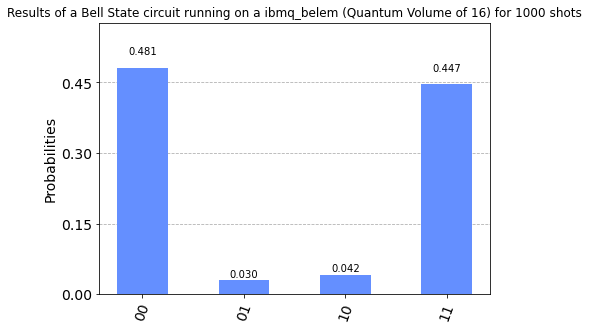

In [15]:
real_hardware_result = execute(bell_circuit, backend=provider.get_backend("ibmq_belem"), shots=1000).result()
real_hardware_counts = real_hardware_result.get_counts()
plot_histogram(real_hardware_counts,title='Results of a Bell State circuit running on a ibmq_belem (Quantum Volume of 16) for 1000 shots')

Now we can generate the calibration circuits and execute the job on the simulator. 

In [16]:
#Generate the measurement calibration circuits
cal_circuits, state_labels = complete_meas_cal(qr = bell_circuit.qregs[0], circlabel = 'mes_error_mitigation_cal')

#Run on the backend simulator so we can build the filter
cal_job_simulated = execute(cal_circuits, backend=provider.get_backend("ibmq_qasm_simulator"), basis_gates=basis_gates,
                  noise_model=noise_model, shots=1000, optimization_level=0)
cal_simulated_results = cal_job_simulated.result()

cal_job_hardware = execute(cal_circuits, backend=provider.get_backend("ibmq_belem"), shots=1000, optimization_level=0)
cal_hardware_results = cal_job_hardware.result()

Lets see what the $2^{2} = 4$ calibration circuits look like.

In [17]:
for circ in cal_circuits:
    print(circ)

       ░ ┌─┐   
 q_0: ─░─┤M├───
       ░ └╥┘┌─┐
 q_1: ─░──╫─┤M├
       ░  ║ └╥┘
c0: 2/════╩══╩═
          0  1 
      ┌───┐ ░ ┌─┐   
 q_0: ┤ X ├─░─┤M├───
      └───┘ ░ └╥┘┌─┐
 q_1: ──────░──╫─┤M├
            ░  ║ └╥┘
c0: 2/═════════╩══╩═
               0  1 
            ░ ┌─┐   
 q_0: ──────░─┤M├───
      ┌───┐ ░ └╥┘┌─┐
 q_1: ┤ X ├─░──╫─┤M├
      └───┘ ░  ║ └╥┘
c0: 2/═════════╩══╩═
               0  1 
      ┌───┐ ░ ┌─┐   
 q_0: ┤ X ├─░─┤M├───
      ├───┤ ░ └╥┘┌─┐
 q_1: ┤ X ├─░──╫─┤M├
      └───┘ ░  ║ └╥┘
c0: 2/═════════╩══╩═
               0  1 


Now let’s build a filter based on the results of measurement and plot on a heatmap. In the heatmap, we should see slightly colored areas along the non-diagonal elements signifying noise. 

First we do the simulated job.

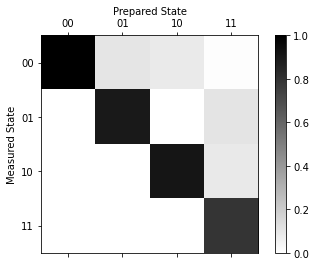

In [18]:
meas_fitter_simulated = CompleteMeasFitter(cal_simulated_results, state_labels)
meas_fitter_simulated.plot_calibration()

Now we do the same for the hardware job.

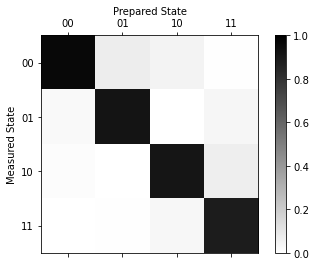

In [19]:
meas_fitter_hardware = CompleteMeasFitter(cal_hardware_results, state_labels)
meas_fitter_hardware.plot_calibration()

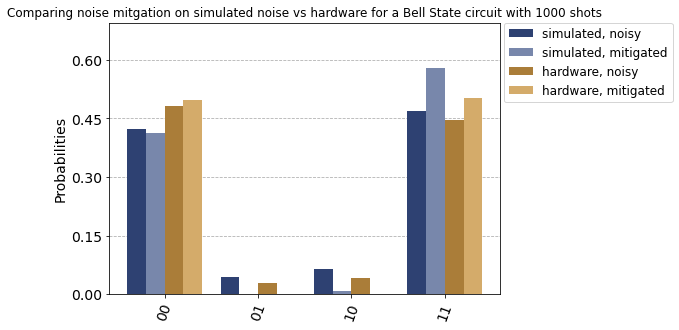

In [20]:
meas_filter_simualted, meas_filter_hardware  = meas_fitter_simulated.filter, meas_fitter_hardware.filter
mitigated_result_simulated, mitigated_result_hardware = meas_filter_simualted.apply(noise_simulated_result),meas_filter_hardware.apply(real_hardware_result)

# counts = real_hardware_result.get_counts(bell_circuit)
mitigated_counts_simulated, mitigated_counts_hardware = mitigated_result_simulated.get_counts(bell_circuit),mitigated_result_hardware.get_counts(bell_circuit)
    
plot_histogram([noise_simulated_counts, mitigated_counts_simulated,
                real_hardware_counts, mitigated_counts_hardware], 
                color=['#2E4172', '#7887AB', '#AA7D39', '#D4AB6A'],
                legend=['simulated, noisy', 'simulated, mitigated',
                        'hardware, noisy', 'hardware, mitigated'],
                title='Comparing noise mitgation on simulated noise vs hardware for a Bell State circuit with 1000 shots',
                bar_labels=False)

As you can see the mitigated results are closer to the 00 and 11 results we were expecting.

Another error correction method that is useful in the NISQ era is QVECTOR which uses a variational circuit approach to learn an ansatz that can encode and decode a quantum circuit. In their tests, they found for circuits with wait time in the error channel that was greater than 3.5 µs outperformed the 5 qubit code. I plan to use this more in future projects.

[Johnson, P. D.; Romero, J.; Olson, J.; Cao, Y.; Aspuru-Guzik, A. QVECTOR: an algorithm for device-tailored quantum error correction. 2017, arXiv:1711.02249](https://arxiv.org/pdf/1711.02249.pdf)